# Regression Kriging: Comparing Covariates (Big Bend)

This document includes Python codes that compare regression kriging with 1) bathymatry, 2) LDI, 3) basymatry+ LDI.

All date are shared in the [box folder](https://usf.box.com/s/xu3dw4i1emv2hzveyf9idnx9q78t939c).

# Table of Contents:

* [1.Load Data](#load_data)
* [2. Combine Discrete and Continuous Data](#preprocess)
* [3. Charlotte Harbor](#ch)
    * [3.1 Preview](#ch_preview)
    * [3.2 Dissolved Oxygen](#do)
        * [3.2.1 Regression Kriging (covariate: bathymetry](#do_bathy)
        * [3.2.2 Regression Kriging: (covariate: LDI)](#do_ldi)
        * [3.2.3 Regression Kriging (covariate: bathymetry+LDI](#do_b_ldi)
        * [3.2.4 Interpolation Validation](#do_val)
    * [3.3 Salinity](#s)
        * [3.3.1 Regression Kriging (covariate: bathymetry](#s_bathy)
        * [3.3.2 Regression Kriging: (covariate: LDI)](#s_ldi)
        * [3.3.3 Regression Kriging (covariate: bathymetry+LDI](#s_b_ldi)
        * [3.3.4 Interpolation Validation](#s_val)
    * [3.4 Total Nitrogen](#tn)
        * [3.4.1 Regression Kriging of Total Nitrogen (covariate: bathymetry](#tn_bathy)
        * [3.4.2 Regression Kriging of Total Nitrogen: (covariate: LDI)](#tn_ldi)
        * [3.4.3 Regression Kriging of Total Nitrogen (covariate: bathymetry+LDI](#tn_b_ldi)
        * [3.4.4 Interpolation Validation of Total Nitrogen](#tn_val)
        
------------------ Not finished --------------------
    * [3.5 Turbidity](#t)
        * [3.5.1 Regression Kriging of Turbidity (covariate: bathymetry](#t_bathy)
        * [3.5.2 Regression Kriging of Turbidity (covariate: LDI)](#t_ldi)
        * [3.5.3 Regression Kriging of Turbidity (covariate: bathymetry+LDI](#t_b_ldi)
        * [3.5.4 Interpolation Validation of Turbidity](#t_val)
    * [3.6 Secchi Depth](#sd)
        * [3.6.1 Regression Kriging of Secchi Depth (covariate: bathymetry](#sd_bathy)
        * [3.6.2 Regression Kriging of Secchi Depth: (covariate: LDI)](#sd_ldi)
        * [3.6.3 Regression Kriging of Secchi Depth (covariate: bathymetry+LDI](#sd_b_ldi)
        * [3.6.4 Interpolation Validation of Secchi Depth](#sd_val)

In [1]:
import time
import math  
import sklearn.metrics  
import arcgisscripting
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio as rio
import rasterio.mask
import rasterio.plot as rio_pl
import matplotlib.image as mpimg
import os
#import rioxarray as rxr

from rasterio.plot import show
from rasterio.transform import Affine
from rasterio.mask import mask
from rasterio import MemoryFile
from rasterio.profiles import DefaultGTiffProfile
from scipy.spatial import Voronoi, voronoi_plot_2d
from scipy.stats import sem
from sklearn.metrics import mean_squared_error
from shapely.geometry import box, Polygon, Point
from shapely import wkt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
import contextily as cx
#from osgeo import gdal
#from pykrige.ok import OrdinaryKriging

# import arcpy and environmental settings
import arcpy
from arcpy.sa import *
import misc.preprocess
import misc.interpolation
arcpy.env.overwriteOutput = True

# 1. Load and Preprocess Data <a class="anchor" id="load_data"></a>

In [2]:
path = "E:/Projects/SEACAR_WQ_Pilot/"
gis_path = path+'GIS_data/'

# path = "D:/Water_Quailty/"
# gis_path = path+'Test02200/'

Preprocess the data and save the preprocessed data in new files

In [3]:
# dfDis, dfCon = misc.preprocess.preprocess(path + r"OEAT_Discrete-2023-Jan-23.csv", 
#                     path + r"OEAT_Continuous_1-2023-Jan-23.csv",
#                     path + r"OEAT_Continuous_2-2023-Jan-23.csv")

# dfDis.to_csv(path + "discrete_0214.csv")
# dfCon.to_csv(path + "continuous_0214.csv")

To save time, we can load the preprocessed "discrete_0214.csv" and "continuous_0214.csv".

In [4]:
#dfDis = pd.read_csv("D:/Water_Quailty/Test0214/discrete_0214.csv")
#dfCon = pd.read_csv("D:/Water_Quailty/Test0214/continuous_0214.csv")

dfDis = pd.read_csv(path + "discrete_0214.csv")
dfCon = pd.read_csv(path + "continuous_0214.csv")

C:\Users\qiangy\AppData\Local\ESRI\conda\envs\geo3\lib\site-packages\IPython\core\interactiveshell.py:3442: DtypeWarning: Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
col_ls = ['RowID','ParameterName','ParameterUnits','ProgramLocationID','ActivityType','ManagedAreaName',
                   'SampleDate','Year','Month','ResultValue','ValueQualifier','Latitude_DD','Longitude_DD']
para_ls = ["Salinity","Total Nitrogen","Dissolved Oxygen","Turbidity","Secchi Depth"]
para_ls_ab = ["S","TN","DO","T","SD"]
# Convert full MA names to short names
dictArea    = {'Gasparilla Sound-Charlotte Harbor Aquatic Preserve':'Charlotte Harbor','Big Bend Seagrasses Aquatic Preserve':'Big Bend',
                'Guana Tolomato Matanzas National Estuarine Research Reserve':'GTM Reserve','Estero Bay Aquatic Preserve':'Estero Bay',
                'Biscayne Bay Aquatic Preserve':'Biscayne Bay','Matlacha Pass Aquatic Preserve':'Matlacha Pass AP',
                'Lemon Bay Aquatic Preserve':'Lemon Bay','Cape Haze Aquatic Preserve':'Cape Haze','Pine Island Sound Aquatic Preserve':'Pine Island'}

# Convert full MA names to MA name in ORCP_Managed_Areas_Oct2021
dictArea2    = {'Gasparilla Sound-Charlotte Harbor Aquatic Preserve':'Gasparilla Sound-Charlotte Harbor','Big Bend Seagrasses Aquatic Preserve':'Big Bend Seagrasses',
                'Guana Tolomato Matanzas National Estuarine Research Reserve':'Guana Tolomato Matanzas NERR','Estero Bay Aquatic Preserve':'Estero Bay',
                'Biscayne Bay Aquatic Preserve':'Biscayne Bay','Matlacha Pass Aquatic Preserve':'Matlacha Pass',
                'Lemon Bay Aquatic Preserve':'Lemon Bay','Cape Haze Aquatic Preserve':'Cape Haze','Pine Island Sound Aquatic Preserve':'Pine Island Sound'}

dictUnits   = {"Salinity":"ppt","Total Nitrogen": "mg/L","Dissolved Oxygen": "mg/L","Turbidity": "NTU", "Secchi Depth": "m"}
listArea    = dfCon["ManagedAreaName"].unique()
listPara    = ["Salinity","Total Nitrogen","Dissolved Oxygen","Turbidity","Secchi Depth"] 
drySeason   = [11,12,1,2,3,4]
wetSeason = [5,6,7,8,9,10]


# dry_start,dry_end = '11/01/2016','04/30/2017'
# wet_start,wet_end = '05/01/2017','10/31/2017'

# 2. Combine Discrete and Continuous Data <a class="anchor" id="combine"></a>

Combine dis and con dataframes

In [6]:
# Set variables of the program
year = "2016"
Area = 'Big Bend Seagrasses Aquatic Preserve'
b_name = 'bb'
Para = 'Dissolved Oxygen'
Para_ab = "DO"
SpatialRef = '3086'

dry_input_pt = gis_path+"Dry"+year+Para_ab+b_name+'.shp'
wet_input_pt = gis_path+"Wet"+year+Para_ab+b_name+'.shp'
boundary_shp = gis_path+ '{}.shp'.format(b_name)

# ---------------------------- Uncomment in the first run --------------------------
dfDryMean, gdfDryAll = misc.preprocess.combine_dis_con_dry(dfDis,dfCon,year)
dfWetMean, gdfWetAll = misc.preprocess.combine_dis_con_wet(dfDis,dfCon,year)

gdfDryAll.to_csv(gis_path+'gdfDryAll{}.csv'.format(year))
gdfWetAll.to_csv(gis_path+'gdfWetAll{}.csv'.format(year))

gdfDrySelect = gdfDryAll[(gdfDryAll["ParameterName"]==Para)&(gdfDryAll["ManagedAreaName"]==Area)]
gdfWetSelect = gdfWetAll[(gdfWetAll["ParameterName"]==Para)&(gdfWetAll["ManagedAreaName"]==Area)]

gdfDrySelect.to_crs(int(SpatialRef)).to_file(dry_input_pt, driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)
gdfWetSelect.to_crs(int(SpatialRef)).to_file(wet_input_pt, driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)

C:\Users\qiangy\AppData\Local\Temp\ipykernel_59240\484656060.py:23: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdfDrySelect.to_crs(int(SpatialRef)).to_file(dry_input_pt, driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)
C:\Users\qiangy\AppData\Local\Temp\ipykernel_59240\484656060.py:24: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdfWetSelect.to_crs(int(SpatialRef)).to_file(wet_input_pt, driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)


Skip the preprocessing and load the pre-stored dataframes

In [7]:
# gdfDryAll = pd.read_csv(gis_path+'gdfDryAll{}.csv'.format(year))
# gdfDryAll = gdfDryAll['geometry'].apply(wkt.loads)
# gdfDryAll = gpd.GeoDataFrame(gdfDryAll, crs='epsg:'+SpatialRef)

# gdfWetAll = pd.read_csv(gis_path+'gdfWetAll{}.csv'.format(year))
# gdfWetAll = gdfWetAll['geometry'].apply(wkt.loads)
# gdfWetAll = gpd.GeoDataFrame(gdfWetAll, crs='epsg:'+SpatialRef)

# 3. Big Bend <a class="anchor" id="ch"></a>
## 3.1 Preview Data <a class="anchor" id="ch_preview"></a>

In [8]:
#MA = gpd.read_file(r"D:\Water_Quailty\ManagedAreas\ORCP_Managed_Areas_Oct2021.shp")
MA = gpd.read_file(gis_path + r"ORCP_Managed_Areas_Oct2021.shp")
CH = MA[MA['MA_Name']==dictArea2[Area]].to_crs(int(SpatialRef))
CH.to_file(boundary_shp , driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)

Also convert all shapefile to Florida GDL Albers (https://epsg.io/3086)

In [9]:
gdfDryShp = gpd.read_file(dry_input_pt)
gdfWetShp = gpd.read_file(wet_input_pt)
extentShp = gpd.read_file(boundary_shp)

Text(0.5, 1.0, 'Sampling points at Big Bend Seagrasses Aquatic Preserve')

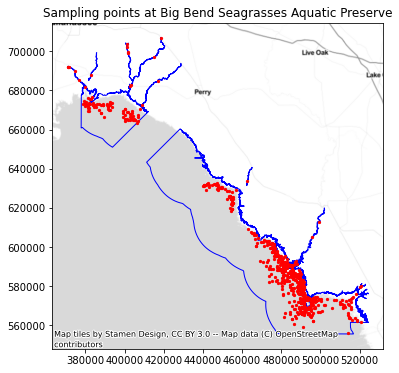

In [10]:
fig, ax = plt.subplots(figsize = (9,6))
extentShp.plot(ax = ax, color='none', edgecolor='blue')
gdfWetShp.plot(ax = ax, marker='o', color='red', markersize=5)
cx.add_basemap(ax = ax,source=cx.providers.Stamen.TonerLite,crs=gdfDryShp.crs)
ax.set_title('Sampling points at {}'.format(Area))

In [11]:
extent = str(extentShp.geometry.total_bounds).replace('[','').replace(']','')

## 3.2 Dissolved Oxygen <a class="anchor" id="do"></a>

### 3.2.1 Regression Kriging (covariate: bathymetry) <a class="anchor" id="do_bathy"></a>

Run Oridinary Kriging with bathymetry as covariate

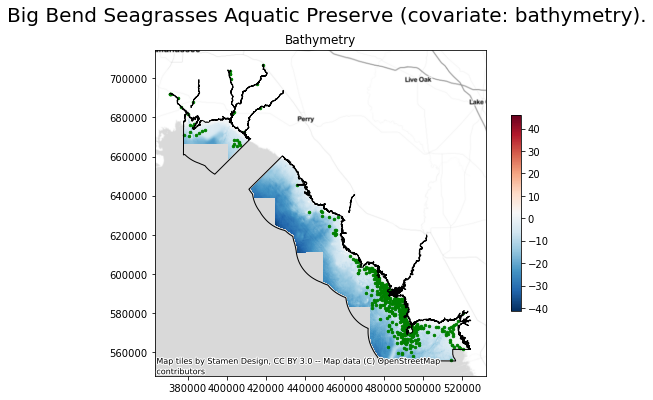

In [12]:
ma_table = pd.read_csv(gis_path + "MA_table.csv")

fig, ax = plt.subplots(1, figsize=(9, 6))
fig.suptitle("{} (covariate: {}).".format(Area, 'bathymetry'),fontsize=20)

ra_fname = gis_path + "covariates/bathymetry/{}.tif".format(dictArea[Area])
misc.interpolation.plot_covariate(Area,gdfDryShp,extentShp,ra_fname,ax, fig)

RK interpolation

In [13]:
season, method, value_field, mask, covariate = 'Dry','rk','ResultValu', gis_path+ '{}.shp'.format(b_name),'bathymetry'
in_explanatory_rasters = gis_path + "covariates/{}/{}.tif".format(covariate, dictArea[Area])

in_features = dry_input_pt 
out_ga_layer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate[0:5])
out_raster = gis_path +"{}{}{}_{}.tif".format(Para_ab, season.lower(),method.upper(),covariate[0:5])

dryRK_2017 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                              z_field = value_field, out_ga_layer = out_ga_layer, extent = extent, 
                                              mask = mask, in_explanatory_rasters = in_explanatory_rasters)

season = 'Wet'
in_features = wet_input_pt 
out_ga_layer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate[0:5])
out_raster = gis_path +"{}{}{}_{}.tif".format(Para_ab, season.lower(),method.upper(),covariate[0:5])

wetRK_2017 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                              z_field = value_field, out_ga_layer = out_ga_layer, extent = extent, 
                                              mask = mask, in_explanatory_rasters = in_explanatory_rasters)

Interpolation using the Regression Kriging method
--- Time lapse: 2125.3716320991516 seconds ---
Interpolation using the Regression Kriging method
--- Time lapse: 2536.1579418182373 seconds ---


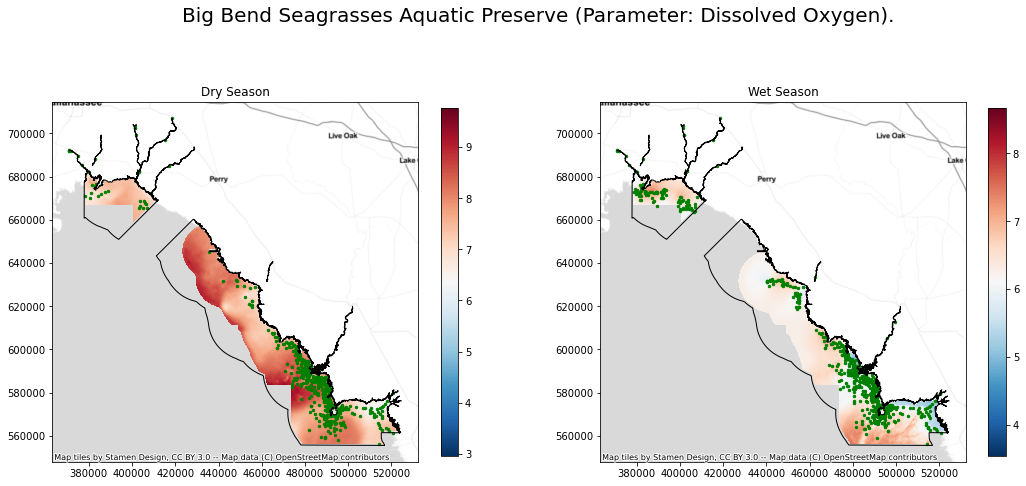

In [14]:
fig, axes = plt.subplots(1,2, figsize=(18, 8))

fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)

misc.interpolation.plot_raster(gdfDryShp, extentShp, dryRK_2017, 'Dry Season', axes[0],fig)
misc.interpolation.plot_raster(gdfWetShp, extentShp, wetRK_2017, 'Wet Season', axes[1],fig)


### 3.2.2 Regression Kriging (covariate: LDI) <a class="anchor" id="do_ldi"></a>


RK interpolation

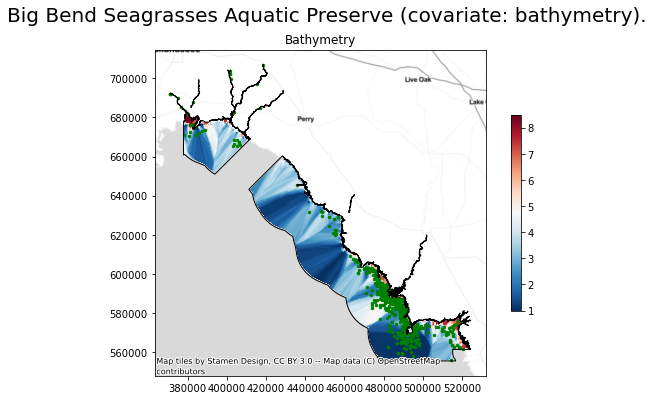

In [15]:
ma_table = pd.read_csv(gis_path + "MA_table.csv")

fig, ax = plt.subplots(1, figsize=(9, 6))
fig.suptitle("{} (covariate: {}).".format(Area, 'bathymetry'),fontsize=20)

ra_fname = gis_path + "covariates/LDI/{}.tif".format(dictArea[Area])
misc.interpolation.plot_covariate(Area,gdfDryShp,extentShp,ra_fname,ax, fig)

In [16]:
season, method, value_field, mask, covariate = 'Dry','rk','ResultValu', gis_path+ '{}.shp'.format(b_name),'ldi'
in_explanatory_rasters = gis_path + "covariates/{}/{}.tif".format(covariate, dictArea[Area])

in_features = dry_input_pt 
out_ga_layer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate[0:5])
out_raster = gis_path +"{}{}{}_{}.tif".format(Para_ab, season.lower(),method.upper(),covariate[0:5])

dryRK_2017 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                              z_field = value_field, out_ga_layer = out_ga_layer, extent = extent, 
                                              mask = mask, in_explanatory_rasters = in_explanatory_rasters)

season = 'Wet'
in_features = wet_input_pt 
out_ga_layer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate[0:5])
out_raster = gis_path +"{}{}{}_{}.tif".format(Para_ab, season.lower(),method.upper(),covariate[0:5])

wetRK_2017 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                              z_field = value_field, out_ga_layer = out_ga_layer, extent = extent, 
                                              mask = mask, in_explanatory_rasters = in_explanatory_rasters)

Interpolation using the Regression Kriging method
--- Time lapse: 2288.817740917206 seconds ---
Interpolation using the Regression Kriging method
--- Time lapse: 2728.8200299739838 seconds ---


Plot the interpolation result

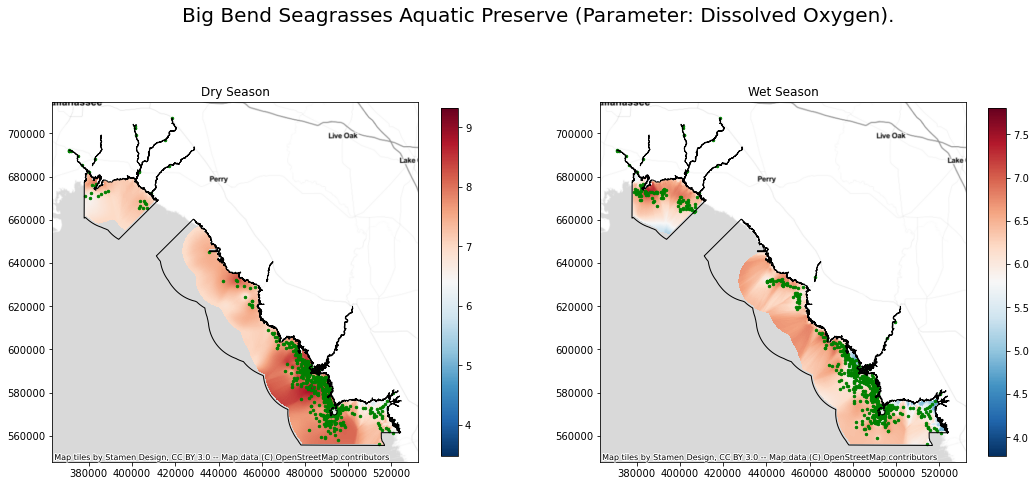

In [17]:
fig, axes = plt.subplots(1,2, figsize=(18, 8))

fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)

misc.interpolation.plot_raster(gdfDryShp, extentShp, dryRK_2017, 'Dry Season', axes[0], fig)
misc.interpolation.plot_raster(gdfWetShp, extentShp, wetRK_2017, 'Wet Season', axes[1], fig)

### 3.2.3 Regression Kriging (covariate: bathymetry + LDI) <a class="anchor" id="do_ldi_bathy"></a>


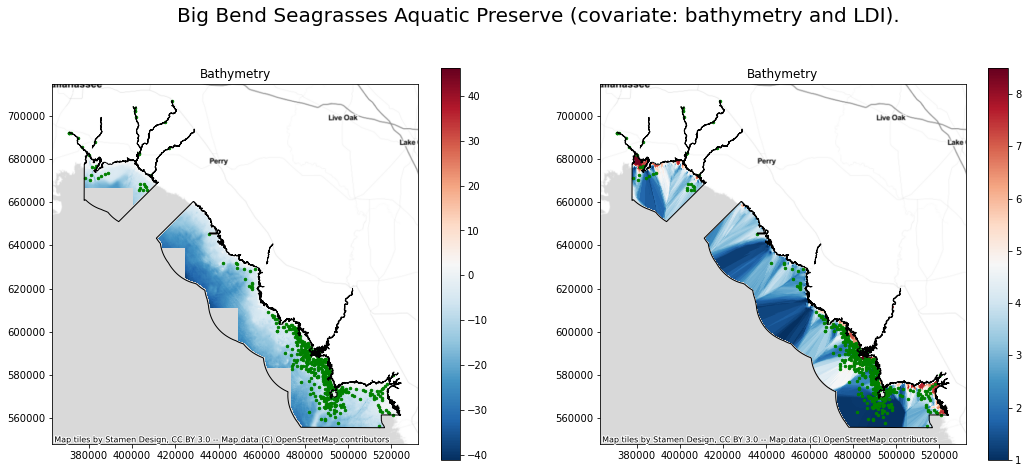

In [18]:
ma_table = pd.read_csv(gis_path + "MA_table.csv")

fig, ax = plt.subplots(1,2, figsize=(18, 12))
fig.suptitle("{} (covariate: {}).".format(Area, 'bathymetry and LDI'),fontsize=20,y=0.8) 

ra_fname = gis_path + "covariates/bathymetry/{}.tif".format(dictArea[Area])
misc.interpolation.plot_covariate(Area,gdfDryShp,extentShp,ra_fname,ax[0], fig)

ra_fname = gis_path + "covariates/ldi/{}.tif".format(dictArea[Area])
misc.interpolation.plot_covariate(Area,gdfDryShp,extentShp,ra_fname,ax[1], fig)


In [19]:
season, method, value_field, mask, covariate = 'Dry','rk','ResultValu', gis_path+ '{}.shp'.format(b_name), 'b_ldi'
in_explanatory_rasters = [gis_path + "covariates/bathymetry/{}.tif".format(dictArea[Area]),
                          gis_path + "covariates/ldi/{}.tif".format(dictArea[Area])]

in_features = dry_input_pt 
out_ga_layer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate[0:5])
out_raster = gis_path +"{}{}{}_{}.tif".format(Para_ab, season.lower(),method.upper(),covariate[0:5])

dryRK_2017 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                              z_field = value_field, out_ga_layer = out_ga_layer, extent = extent, 
                                              mask = mask, in_explanatory_rasters = in_explanatory_rasters)

season = 'Wet'
in_features = wet_input_pt 
out_ga_layer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate[0:5])
out_raster = gis_path +"{}{}{}_{}.tif".format(Para_ab, season.lower(),method.upper(),covariate[0:5])

wetRK_2017 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                              z_field = 'ResultValu', out_ga_layer = out_ga_layer, extent = extent, 
                                              mask = mask, in_explanatory_rasters = in_explanatory_rasters)

Interpolation using the Regression Kriging method
--- Time lapse: 3620.7899177074432 seconds ---
Interpolation using the Regression Kriging method
--- Time lapse: 4225.574684381485 seconds ---


Plot interpolation results

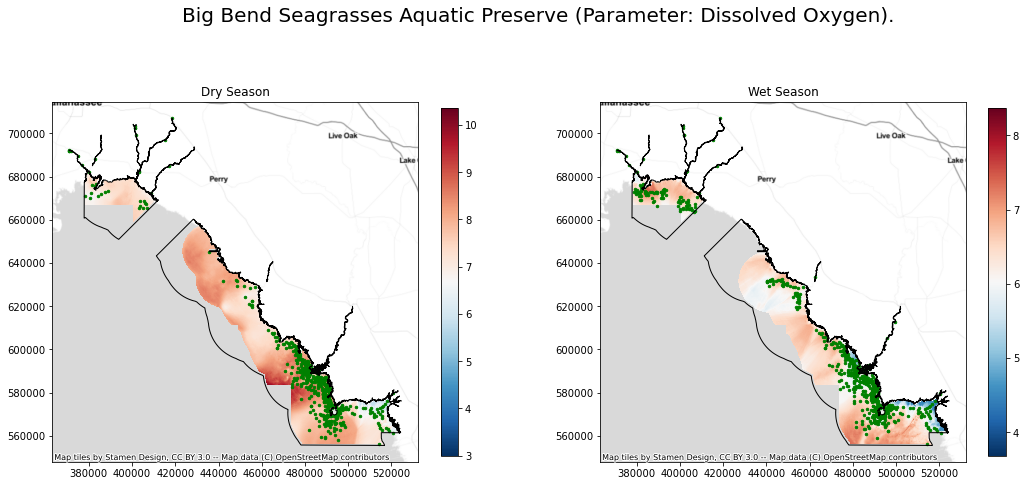

In [20]:
fig, axes = plt.subplots(1,2, figsize=(18, 8))

fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)

misc.interpolation.plot_raster(gdfDryShp, extentShp, dryRK_2017, 'Dry Season', axes[0],fig)
misc.interpolation.plot_raster(gdfWetShp, extentShp, wetRK_2017, 'Wet Season', axes[1],fig)


## 3.2.4 Interpolation Validation <a class="anchor" id="do_val"></a>

Validate RK with bathymetry

In [21]:
method, season, covariate = 'rk', 'dry', 'bathymetry'
inLayer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate[0:5])

dryRKStat1 = misc.interpolation.extract_val_result(inLayer,covariate)

season = 'wet'
inLayer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate[0:5])

wetRKStat1 = misc.interpolation.extract_val_result(inLayer,covariate)

Display validation result

In [22]:
print("Validation of Regression Kriging in dry season data")
display(dryRKStat1)
print("Validation of Regression Kriging in wet season data")
display(wetRKStat1)

Validation of Regression Kriging in dry season data


,meanError,meanStandardizedError,rootMeanSquareError
bathymetry,0.0241,0.0149,1.6349


Validation of Regression Kriging in wet season data


,meanError,meanStandardizedError,rootMeanSquareError
bathymetry,0.0135,0.0156,1.2627


Validation of RK with ldi as covariate

In [23]:
method, season, covariate = 'rk', 'dry', 'ldi'
inLayer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate[0:5])

dryRKStat2 = misc.interpolation.extract_val_result(inLayer,covariate)

season = 'wet'
inLayer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate[0:5])

wetRKStat2 = misc.interpolation.extract_val_result(inLayer,covariate)

Display validation result

In [24]:
print("Validation of Regression Kriging in dry season data")
display(dryRKStat2)
print("Validation of Regression Kriging in wet season data")
display(wetRKStat2)

Validation of Regression Kriging in dry season data


,meanError,meanStandardizedError,rootMeanSquareError
ldi,0.0158,0.0092,1.6407


Validation of Regression Kriging in wet season data


,meanError,meanStandardizedError,rootMeanSquareError
ldi,0.0022,0.0068,1.2572


Validate RK with Bathymetry & LDI

In [25]:
method, season, covariate = 'rk', 'dry', 'b_ldi'
inLayer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate[0:5])

dryRKStat3 = misc.interpolation.extract_val_result(inLayer,covariate)

season = 'wet'
inLayer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate[0:5])

wetRKStat3 = misc.interpolation.extract_val_result(inLayer,covariate)

Display validation result

In [26]:
print("Interpolation assessment of Regression Kriging in dry season data")
display(dryRKStat3)
print("Interpolation assessment of Regression Kriging in wet season data")
display(wetRKStat3)

Interpolation assessment of Regression Kriging in dry season data


,meanError,meanStandardizedError,rootMeanSquareError
b_ldi,0.0208,0.0118,1.6293


Interpolation assessment of Regression Kriging in wet season data


,meanError,meanStandardizedError,rootMeanSquareError
b_ldi,0.0142,0.0147,1.2556


#### Summary of validation

In [27]:
sumStatDry_ch = pd.concat([dryRKStat1,dryRKStat2,dryRKStat3])
sumStatWet_ch = pd.concat([wetRKStat1,wetRKStat2,wetRKStat3])

display("Summary of interpolation validation in dry season data")
display(sumStatDry_ch)

display("Summary of interpolation validation in wet season data")
display(sumStatWet_ch)

'Summary of interpolation validation in dry season data'

,meanError,meanStandardizedError,rootMeanSquareError
bathymetry,0.0241,0.0149,1.6349
ldi,0.0158,0.0092,1.6407
b_ldi,0.0208,0.0118,1.6293


'Summary of interpolation validation in wet season data'

,meanError,meanStandardizedError,rootMeanSquareError
bathymetry,0.0135,0.0156,1.2627
ldi,0.0022,0.0068,1.2572
b_ldi,0.0142,0.0147,1.2556


## 3.3 Interpolation of Salinity <a class="anchor" id="s"></a>

Select salinity data

In [28]:
# Set variables of the program
Para = 'Salinity'
Para_ab = "S"

dry_input_pt = gis_path+"Dry"+year+Para_ab+b_name+'.shp'
wet_input_pt = gis_path+"Wet"+year+Para_ab+b_name+'.shp'

# ---------------------------- Uncomment in the first run --------------------------

gdfDrySelect = gdfDryAll[(gdfDryAll["ParameterName"]==Para)&(gdfDryAll["ManagedAreaName"]==Area)]
gdfWetSelect = gdfWetAll[(gdfWetAll["ParameterName"]==Para)&(gdfWetAll["ManagedAreaName"]==Area)]

gdfDrySelect.to_crs(int(SpatialRef)).to_file(dry_input_pt , driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)
gdfWetSelect.to_crs(int(SpatialRef)).to_file(wet_input_pt , driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)

C:\Users\qiangy\AppData\Local\Temp\ipykernel_59240\1647803667.py:13: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdfDrySelect.to_crs(int(SpatialRef)).to_file(dry_input_pt , driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)
C:\Users\qiangy\AppData\Local\Temp\ipykernel_59240\1647803667.py:14: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdfWetSelect.to_crs(int(SpatialRef)).to_file(wet_input_pt , driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)


### 3.3.1 Regression Kriging of Salinity (covariate: bathymetry) <a class="anchor" id="s_bathy"></a>

In [29]:
#MA = gpd.read_file(r"D:\Water_Quailty\ManagedAreas\ORCP_Managed_Areas_Oct2021.shp")
MA = gpd.read_file(gis_path + r"ORCP_Managed_Areas_Oct2021.shp")
CH = MA[MA['MA_Name']==dictArea2[Area]].to_crs(int(SpatialRef))
CH.to_file(boundary_shp, driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)

Also convert all shapefile to Florida GDL Albers (https://epsg.io/3086)

In [30]:
gdfDryShp = gpd.read_file(dry_input_pt)
gdfWetShp = gpd.read_file(wet_input_pt)
extentShp = gpd.read_file(boundary_shp)

Text(0.5, 1.0, 'Sampling points at Big Bend Seagrasses Aquatic Preserve')

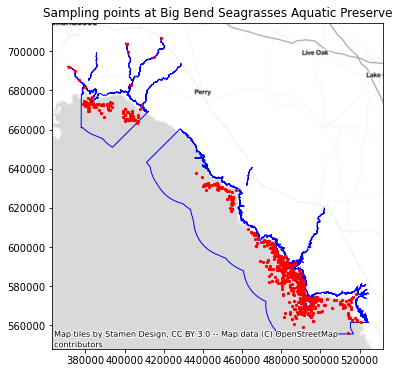

In [31]:
fig, ax = plt.subplots(figsize = (9,6))
extentShp.plot(ax = ax, color='none', edgecolor='blue')
gdfWetShp.plot(ax = ax, marker='o', color='red', markersize=5)
cx.add_basemap(ax = ax,source=cx.providers.Stamen.TonerLite,crs=gdfDryShp.crs)
ax.set_title('Sampling points at {}'.format(Area))

In [32]:
extent = str(extentShp.geometry.total_bounds).replace('[','').replace(']','')

### 3.3.1 Regression Kriging  of Salinity (covariate: bathymetry) <a class="anchor" id="s_bathy"></a>

Run Oridinary Kriging with bathymetry as covariate

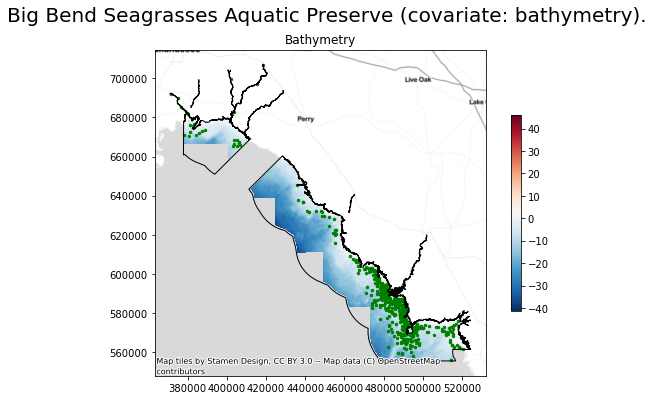

In [33]:
ma_table = pd.read_csv(gis_path + "MA_table.csv")

fig, ax = plt.subplots(1, figsize=(9, 6))
fig.suptitle("{} (covariate: {}).".format(Area, 'bathymetry'),fontsize=20)

ra_fname = gis_path + "covariates/bathymetry/{}.tif".format(dictArea[Area])
misc.interpolation.plot_covariate(Area,gdfDryShp,extentShp,ra_fname,ax, fig)

RK interpolation

In [34]:
season, method, value_field, mask, covariate = 'Dry','rk','ResultValu', gis_path+ '{}.shp'.format(b_name),'bathymetry'
in_explanatory_rasters = gis_path + "covariates/{}/{}.tif".format(covariate, dictArea[Area])

in_features = dry_input_pt 
out_ga_layer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate[0:5])
out_raster = gis_path +"{}{}{}_{}.tif".format(Para_ab, season.lower(),method.upper(),covariate[0:5])

dryRK_2017 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                              z_field = value_field, out_ga_layer = out_ga_layer, extent = extent, 
                                              mask = mask, in_explanatory_rasters = in_explanatory_rasters)

season = 'Wet'
in_features = wet_input_pt 
out_ga_layer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate[0:5])
out_raster = gis_path +"{}{}{}_{}.tif".format(Para_ab, season.lower(),method.upper(),covariate[0:5])

wetRK_2017 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                              z_field = value_field, out_ga_layer = out_ga_layer, extent = extent, 
                                              mask = mask, in_explanatory_rasters = in_explanatory_rasters)

Interpolation using the Regression Kriging method
--- Time lapse: 1745.1737129688263 seconds ---
Interpolation using the Regression Kriging method
--- Time lapse: 2050.2052376270294 seconds ---


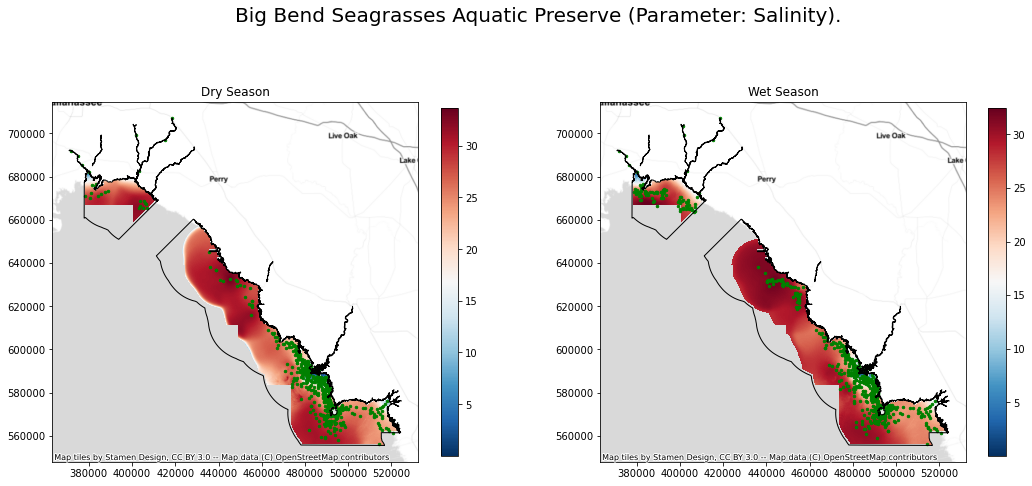

In [35]:
fig, axes = plt.subplots(1,2, figsize=(18, 8))

fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)

misc.interpolation.plot_raster(gdfDryShp, extentShp, dryRK_2017, 'Dry Season', axes[0],fig)
misc.interpolation.plot_raster(gdfWetShp, extentShp, wetRK_2017, 'Wet Season', axes[1],fig)


### 3.3.2 Regression Kriging of Salinity (covariate: LDI) <a class="anchor" id="s_ldi"></a>


RK interpolation

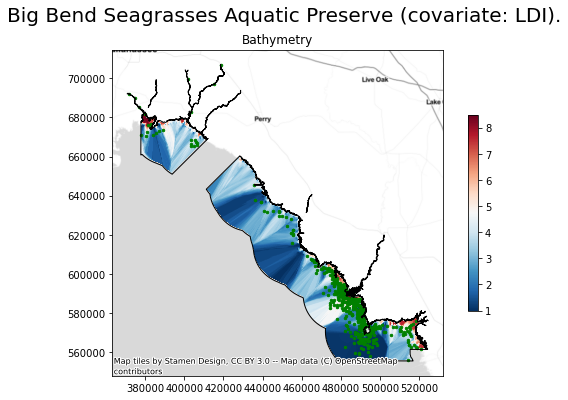

In [36]:
ma_table = pd.read_csv(gis_path + "MA_table.csv")

fig, ax = plt.subplots(1, figsize=(9, 6))
fig.suptitle("{} (covariate: {}).".format(Area, 'LDI'),fontsize=20)

ra_fname = gis_path + "covariates/LDI/{}.tif".format(dictArea[Area])
misc.interpolation.plot_covariate(Area,gdfDryShp,extentShp,ra_fname,ax, fig)

In [37]:
season, method, value_field, mask, covariate = 'Dry','rk','ResultValu', gis_path+ '{}.shp'.format(b_name),'ldi'
in_explanatory_rasters = gis_path + "covariates/{}/{}.tif".format(covariate, dictArea[Area])

in_features = dry_input_pt 
out_ga_layer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate[0:5])
out_raster = gis_path +"{}{}{}_{}.tif".format(Para_ab, season.lower(),method.upper(),covariate[0:5])

dryRK_2017 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                              z_field = value_field, out_ga_layer = out_ga_layer, extent = extent, 
                                              mask = mask, in_explanatory_rasters = in_explanatory_rasters)

season = 'Wet'
in_features = wet_input_pt 
out_ga_layer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate[0:5])
out_raster = gis_path +"{}{}{}_{}.tif".format(Para_ab, season.lower(),method.upper(),covariate[0:5])

wetRK_2017 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                              z_field = value_field, out_ga_layer = out_ga_layer, extent = extent, 
                                              mask = mask, in_explanatory_rasters = in_explanatory_rasters)

Interpolation using the Regression Kriging method
--- Time lapse: 1950.5581455230713 seconds ---
Interpolation using the Regression Kriging method
--- Time lapse: 2439.346809387207 seconds ---


Plot the interpolation result

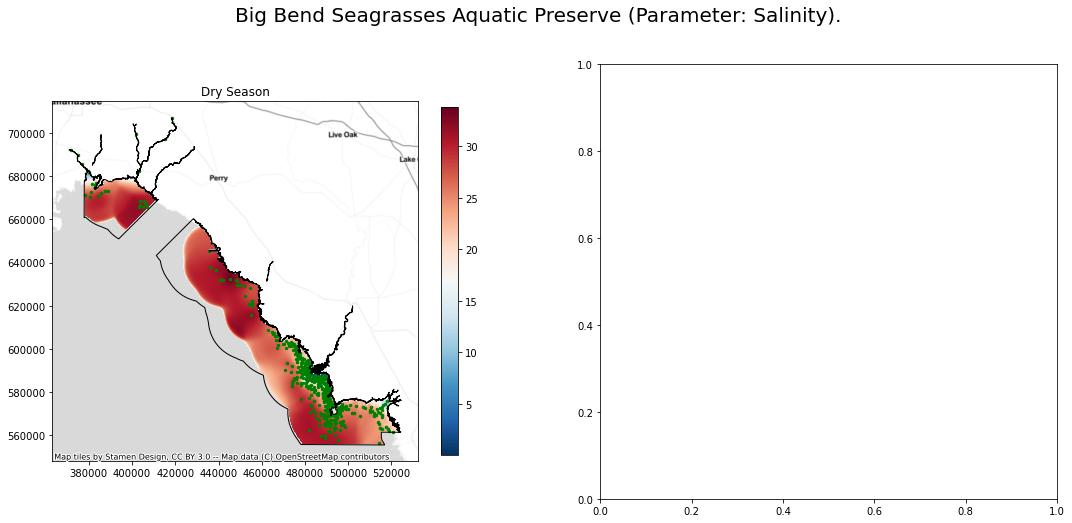

In [38]:
fig, axes = plt.subplots(1,2, figsize=(18, 8))

fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)

misc.interpolation.plot_raster(gdfDryShp, extentShp, dryRK_2017, 'Dry Season', axes[0], fig)
# misc.interpolation.plot_raster(gdfWetShp, extentShp, wetRK_2017, 'Wet Season', axes[1], fig)

### 3.3.3 Regression Kriging of Salinity (covariate: bathymetry + LDI) <a class="anchor" id="s_ldi_bathy"></a>


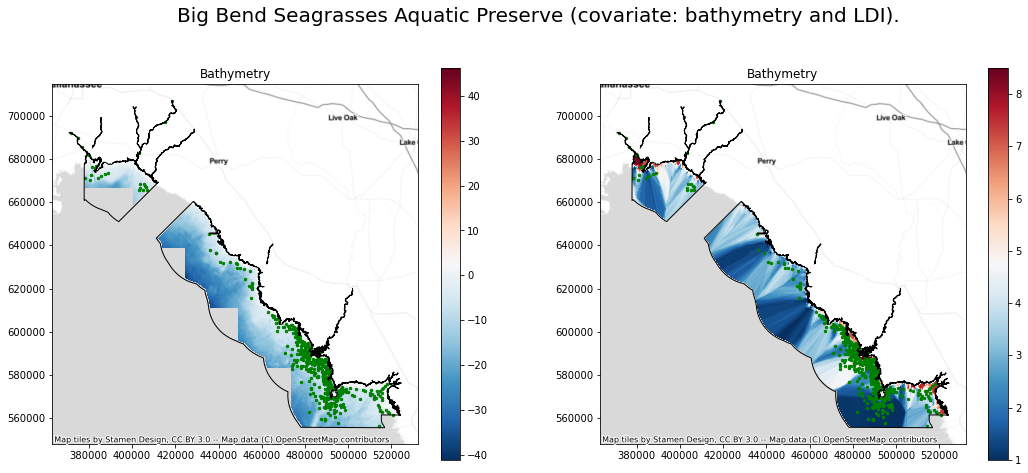

In [39]:
ma_table = pd.read_csv(gis_path + "MA_table.csv")

fig, ax = plt.subplots(1,2, figsize=(18, 12))
fig.suptitle("{} (covariate: {}).".format(Area, 'bathymetry and LDI'),fontsize=20,y=0.8) 

ra_fname = gis_path + "covariates/bathymetry/{}.tif".format(dictArea[Area])
misc.interpolation.plot_covariate(Area,gdfDryShp,extentShp,ra_fname,ax[0], fig)

ra_fname = gis_path + "covariates/ldi/{}.tif".format(dictArea[Area])
misc.interpolation.plot_covariate(Area,gdfDryShp,extentShp,ra_fname,ax[1], fig)


In [40]:
season, method, value_field, mask, covariate = 'Dry','rk','ResultValu', gis_path+ '{}.shp'.format(b_name), 'b_ldi'
in_explanatory_rasters = [gis_path + "covariates/bathymetry/{}.tif".format(dictArea[Area]),
                          gis_path + "covariates/ldi/{}.tif".format(dictArea[Area])]

in_features = dry_input_pt 
out_ga_layer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate[0:5])
out_raster = gis_path +"{}{}{}_{}.tif".format(Para_ab, season.lower(),method.upper(),covariate[0:5])

dryRK_2017 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                              z_field = value_field, out_ga_layer = out_ga_layer, extent = extent, 
                                              mask = mask, in_explanatory_rasters = in_explanatory_rasters)

season = 'Wet'
in_features = wet_input_pt 
out_ga_layer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate[0:5])
out_raster = gis_path +"{}{}{}_{}.tif".format(Para_ab, season.lower(),method.upper(),covariate[0:5])

wetRK_2017 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                              z_field = 'ResultValu', out_ga_layer = out_ga_layer, extent = extent, 
                                              mask = mask, in_explanatory_rasters = in_explanatory_rasters)

Interpolation using the Regression Kriging method
--- Time lapse: 3173.132688522339 seconds ---
Interpolation using the Regression Kriging method
--- Time lapse: 3757.1009118556976 seconds ---


Plot interpolation results

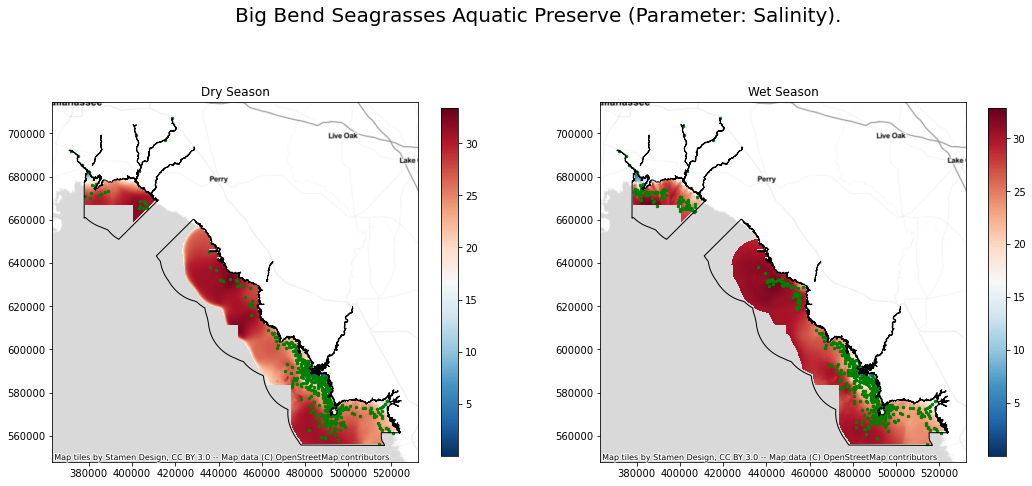

In [41]:
fig, axes = plt.subplots(1,2, figsize=(18, 8))

fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)

misc.interpolation.plot_raster(gdfDryShp, extentShp, dryRK_2017, 'Dry Season', axes[0],fig)
misc.interpolation.plot_raster(gdfWetShp, extentShp, wetRK_2017, 'Wet Season', axes[1],fig)


### 3.3.4 Interpolation Validation of Salinity <a class="anchor" id="s_val"></a>

Validate RK with bathymetry

In [42]:
def extract_val_result(inLayer, index):
    cvResult = arcpy.CrossValidation_ga(inLayer)
    Stat = pd.DataFrame(
                {
                  "meanError": round(float(cvResult.meanError),4),
                  "meanStandardizedError": round(float(cvResult.meanStandardized),4),
                  "rootMeanSquareError": round(float(cvResult.rootMeanSquare),4)
                                              },index=[index])
    return Stat

In [43]:
method, season, covariate = 'rk', 'dry', 'bathymetry'
inLayer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate[0:5])

dryRKStat1 = extract_val_result(inLayer,covariate)

season = 'wet'
inLayer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate[0:5])

wetRKStat1 = extract_val_result(inLayer,covariate)

Display validation result

In [44]:
print("Validation of Regression Kriging in dry season data")
display(dryRKStat1)
print("Validation of Regression Kriging in wet season data")
display(wetRKStat1)

Validation of Regression Kriging in dry season data


,meanError,meanStandardizedError,rootMeanSquareError
bathymetry,-0.0621,-0.0192,3.9707


Validation of Regression Kriging in wet season data


,meanError,meanStandardizedError,rootMeanSquareError
bathymetry,0.0298,0.0079,3.6475


Validation of RK with ldi as covariate

In [45]:
method, season, covariate = 'rk', 'dry', 'ldi'
inLayer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate[0:5])

dryRKStat2 = extract_val_result(inLayer,covariate)

season = 'wet'
inLayer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate[0:5])

wetRKStat2 = extract_val_result(inLayer,covariate)

Display validation result

In [46]:
print("Validation of Regression Kriging in dry season data")
display(dryRKStat2)
print("Validation of Regression Kriging in wet season data")
display(wetRKStat2)

Validation of Regression Kriging in dry season data


,meanError,meanStandardizedError,rootMeanSquareError
ldi,-0.1005,-0.0286,3.9735


Validation of Regression Kriging in wet season data


,meanError,meanStandardizedError,rootMeanSquareError
ldi,0.0369,0.0115,3.5916


Validate RK with Bathymetry & LDI

In [47]:
method, season, covariate = 'rk', 'dry', 'b_ldi'
inLayer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate[0:5])

dryRKStat3 = extract_val_result(inLayer,covariate)

season = 'wet'
inLayer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate[0:5])

wetRKStat3 = extract_val_result(inLayer,covariate)

Display validation result

In [48]:
print("Interpolation assessment of Regression Kriging in dry season data")
display(dryRKStat3)
print("Interpolation assessment of Regression Kriging in wet season data")
display(wetRKStat3)

Interpolation assessment of Regression Kriging in dry season data


,meanError,meanStandardizedError,rootMeanSquareError
b_ldi,-0.0964,-0.0257,3.9734


Interpolation assessment of Regression Kriging in wet season data


,meanError,meanStandardizedError,rootMeanSquareError
b_ldi,0.0008,0.0038,3.5768


#### Summary of validation

In [49]:
sumStatDry_ch = pd.concat([dryRKStat1,dryRKStat2,dryRKStat3])
sumStatWet_ch = pd.concat([wetRKStat1,wetRKStat2,wetRKStat3])

display("Summary of interpolation validation in dry season data")
display(sumStatDry_ch)

display("Summary of interpolation validation in wet season data")
display(sumStatWet_ch)

'Summary of interpolation validation in dry season data'

,meanError,meanStandardizedError,rootMeanSquareError
bathymetry,-0.0621,-0.0192,3.9707
ldi,-0.1005,-0.0286,3.9735
b_ldi,-0.0964,-0.0257,3.9734


'Summary of interpolation validation in wet season data'

,meanError,meanStandardizedError,rootMeanSquareError
bathymetry,0.0298,0.0079,3.6475
ldi,0.0369,0.0115,3.5916
b_ldi,0.0008,0.0038,3.5768


## 3.4 Interpolation of Total Nitrogen <a class="anchor" id="tn"></a>

Select data

In [50]:
# Set variables of the program
Para = 'Total Nitrogen'
Para_ab = "TN"

dry_input_pt = gis_path+"Dry"+year+Para_ab+b_name+'.shp'
wet_input_pt = gis_path+"Wet"+year+Para_ab+b_name+'.shp'


gdfDrySelect = gdfDryAll[(gdfDryAll["ParameterName"]==Para)&(gdfDryAll["ManagedAreaName"]==Area)]
gdfWetSelect = gdfWetAll[(gdfWetAll["ParameterName"]==Para)&(gdfWetAll["ManagedAreaName"]==Area)]

gdfDrySelect.to_crs(int(SpatialRef)).to_file(dry_input_pt , driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)
gdfWetSelect.to_crs(int(SpatialRef)).to_file(wet_input_pt , driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)

C:\Users\qiangy\AppData\Local\Temp\ipykernel_59240\2072250353.py:12: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdfDrySelect.to_crs(int(SpatialRef)).to_file(dry_input_pt , driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)
C:\Users\qiangy\AppData\Local\Temp\ipykernel_59240\2072250353.py:13: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdfWetSelect.to_crs(int(SpatialRef)).to_file(wet_input_pt , driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)


Preview data

In [51]:
#MA = gpd.read_file(r"D:\Water_Quailty\ManagedAreas\ORCP_Managed_Areas_Oct2021.shp")
b_name = 'ch'
MA = gpd.read_file(gis_path + r"ORCP_Managed_Areas_Oct2021.shp")
CH = MA[MA['MA_Name']==dictArea2[Area]].to_crs(int(SpatialRef))
CH.to_file(boundary_shp, driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)

Also convert all shapefile to Florida GDL Albers (https://epsg.io/3086)

In [52]:
gdfDryShp = gpd.read_file(dry_input_pt)
gdfWetShp = gpd.read_file(wet_input_pt)
extentShp = gpd.read_file(boundary_shp)

Text(0.5, 1.0, 'Sampling points at Big Bend Seagrasses Aquatic Preserve')

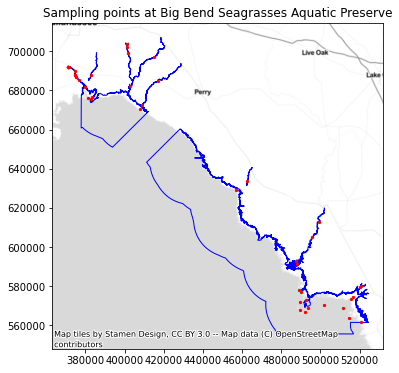

In [53]:
fig, ax = plt.subplots(figsize = (9,6))
extentShp.plot(ax = ax, color='none', edgecolor='blue')
gdfWetShp.plot(ax = ax, marker='o', color='red', markersize=5)
cx.add_basemap(ax = ax,source=cx.providers.Stamen.TonerLite,crs=gdfDryShp.crs)
ax.set_title('Sampling points at {}'.format(Area))

In [54]:
extent = str(extentShp.geometry.total_bounds).replace('[','').replace(']','')

### 3.4.1 Regression Kriging of Total Nitrogen (covariate: bathymetry) <a class="anchor" id="tn_bathy"></a>

Run Oridinary Kriging with bathymetry as covariate

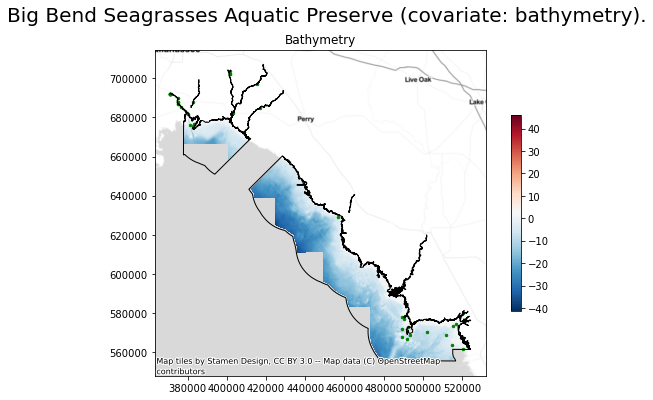

In [55]:
ma_table = pd.read_csv(gis_path + "MA_table.csv")

fig, ax = plt.subplots(1, figsize=(9, 6))
fig.suptitle("{} (covariate: {}).".format(Area, 'bathymetry'),fontsize=20)

ra_fname = gis_path + "covariates/bathymetry/{}.tif".format(dictArea[Area])
misc.interpolation.plot_covariate(Area,gdfDryShp,extentShp,ra_fname,ax, fig)

RK interpolation

In [56]:
year, season, method, value_field, mask, covariate = '2017', 'Dry','rk','ResultValu', gis_path+ '{}.shp'.format(b_name),'bathymetry'
in_explanatory_rasters = gis_path + "covariates/{}/{}.tif".format(covariate, dictArea[Area])

in_features = dry_input_pt 
out_ga_layer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate[0:5])
out_raster = gis_path +"{}{}{}_{}.tif".format(Para_ab, season.lower(),method.upper(),covariate[0:5])

dryRK_2017 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                              z_field = value_field, out_ga_layer = out_ga_layer, extent = extent, 
                                              mask = mask, in_explanatory_rasters = in_explanatory_rasters)

season = 'Wet'
in_features = wet_input_pt 
out_ga_layer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate[0:5])
out_raster = gis_path +"{}{}{}_{}.tif".format(Para_ab, season.lower(),method.upper(),covariate[0:5])

wetRK_2017 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                              z_field = value_field, out_ga_layer = out_ga_layer, extent = extent, 
                                              mask = mask, in_explanatory_rasters = in_explanatory_rasters)

Interpolation using the Regression Kriging method
--- Time lapse: 17.11936855316162 seconds ---
Interpolation using the Regression Kriging method
--- Time lapse: 15.847065210342407 seconds ---


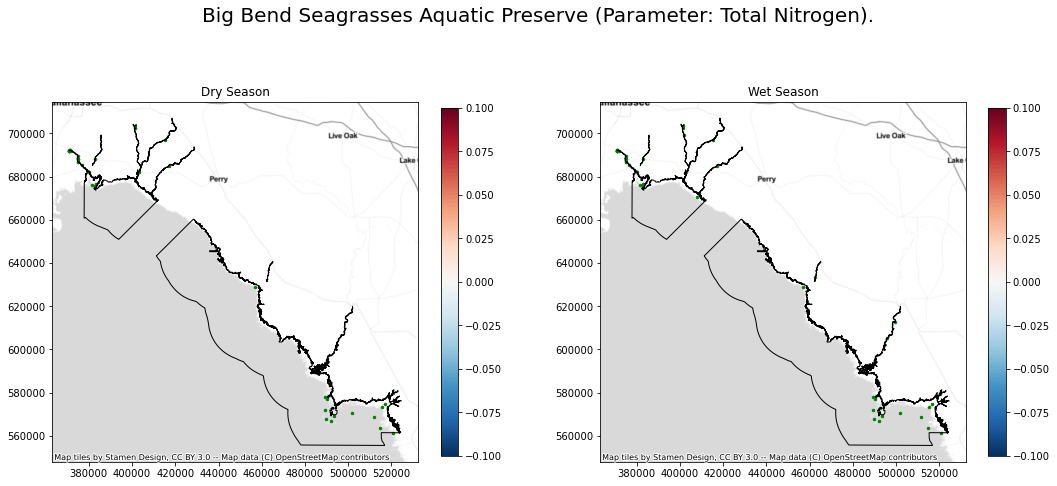

In [57]:
fig, axes = plt.subplots(1,2, figsize=(18, 8))

fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)

misc.interpolation.plot_raster(gdfDryShp, extentShp, dryRK_2017, 'Dry Season', axes[0],fig)
misc.interpolation.plot_raster(gdfWetShp, extentShp, wetRK_2017, 'Wet Season', axes[1],fig)


### 3.4.2 Regression Kriging of Total Nitrogen (covariate: LDI) <a class="anchor" id="tn_ldi"></a>


RK interpolation

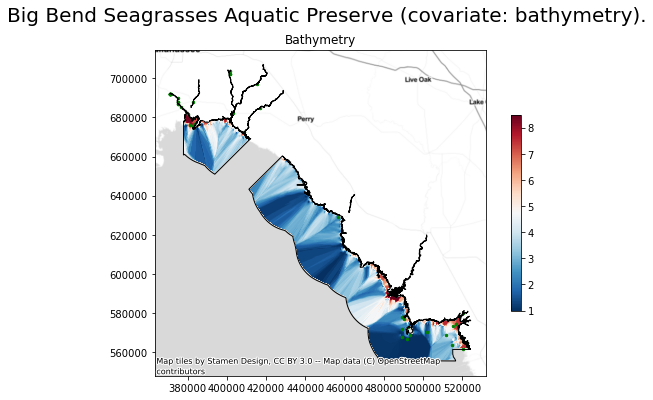

In [58]:
ma_table = pd.read_csv(gis_path + "MA_table.csv")

fig, ax = plt.subplots(1, figsize=(9, 6))
fig.suptitle("{} (covariate: {}).".format(Area, 'bathymetry'),fontsize=20)

ra_fname = gis_path + "covariates/LDI/{}.tif".format(dictArea[Area])
misc.interpolation.plot_covariate(Area,gdfDryShp,extentShp,ra_fname,ax, fig)

In [59]:
year, season, method, value_field, mask, covariate = '2017', 'Dry','rk','ResultValu', gis_path+ '{}.shp'.format(b_name),'ldi'
in_explanatory_rasters = gis_path + "covariates/{}/{}.tif".format(covariate, dictArea[Area])

in_features = dry_input_pt 
out_ga_layer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate[0:5])
out_raster = gis_path +"{}{}{}_{}.tif".format(Para_ab, season.lower(),method.upper(),covariate[0:5])

dryRK_2017 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                              z_field = value_field, out_ga_layer = out_ga_layer, extent = extent, 
                                              mask = mask, in_explanatory_rasters = in_explanatory_rasters)

season = 'Wet'
in_features = wet_input_pt 
out_ga_layer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate[0:5])
out_raster = gis_path +"{}{}{}_{}.tif".format(Para_ab, season.lower(),method.upper(),covariate[0:5])

wetRK_2017 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                              z_field = value_field, out_ga_layer = out_ga_layer, extent = extent, 
                                              mask = mask, in_explanatory_rasters = in_explanatory_rasters)

Interpolation using the Regression Kriging method
--- Time lapse: 30.357572078704834 seconds ---
Interpolation using the Regression Kriging method
--- Time lapse: 30.299736738204956 seconds ---


Plot the interpolation result

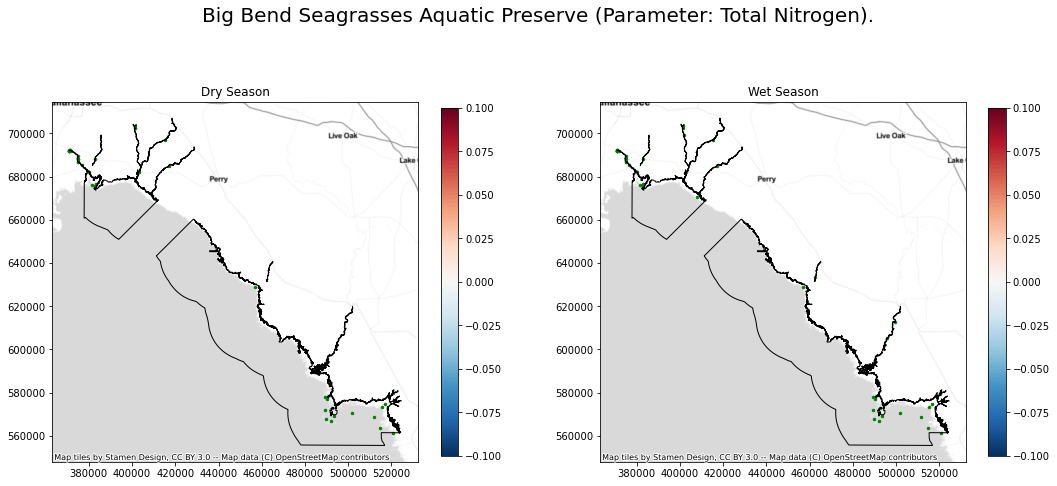

In [60]:
fig, axes = plt.subplots(1,2, figsize=(18, 8))

fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)

misc.interpolation.plot_raster(gdfDryShp, extentShp, dryRK_2017, 'Dry Season', axes[0], fig)
misc.interpolation.plot_raster(gdfWetShp, extentShp, wetRK_2017, 'Wet Season', axes[1], fig)

### 3.4.3 Regression Kriging of Total Nitrogen (covariate: bathymetry + LDI) <a class="anchor" id="tn_b_ldi"></a>


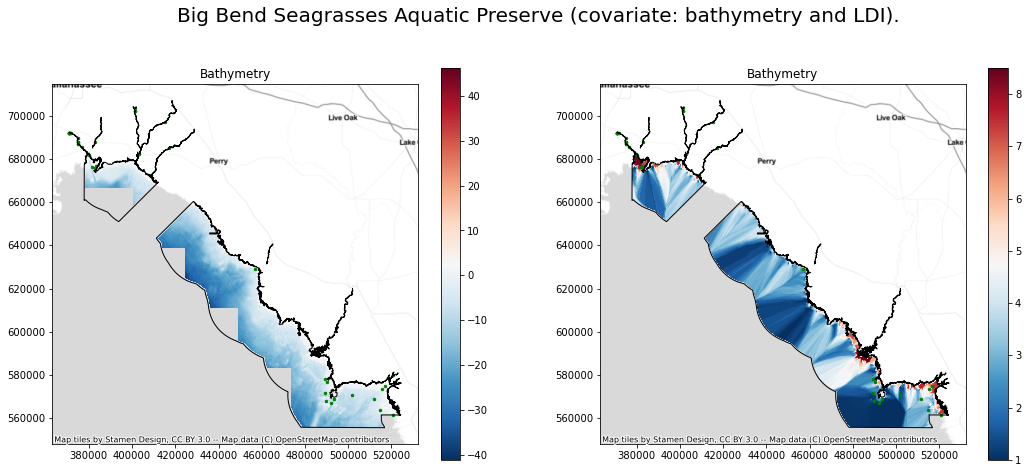

In [61]:
ma_table = pd.read_csv(gis_path + "MA_table.csv")

fig, ax = plt.subplots(1,2, figsize=(18, 12))
fig.suptitle("{} (covariate: {}).".format(Area, 'bathymetry and LDI'),fontsize=20,y=0.8) 

ra_fname = gis_path + "covariates/bathymetry/{}.tif".format(dictArea[Area])
misc.interpolation.plot_covariate(Area,gdfDryShp,extentShp,ra_fname,ax[0], fig)

ra_fname = gis_path + "covariates/ldi/{}.tif".format(dictArea[Area])
misc.interpolation.plot_covariate(Area,gdfDryShp,extentShp,ra_fname,ax[1], fig)


In [62]:
year, season, method, value_field, mask, covariate = '2017', 'Dry','rk','ResultValu', gis_path+ '{}.shp'.format(b_name), 'b_ldi'
in_explanatory_rasters = [gis_path + "covariates/bathymetry/{}.tif".format(dictArea[Area]),
                          gis_path + "covariates/ldi/{}.tif".format(dictArea[Area])]

in_features = dry_input_pt 
out_ga_layer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate[0:5])
out_raster = gis_path +"{}{}{}_{}.tif".format(Para_ab, season.lower(),method.upper(),covariate[0:5])

dryRK_2017 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                              z_field = value_field, out_ga_layer = out_ga_layer, extent = extent, 
                                              mask = mask, in_explanatory_rasters = in_explanatory_rasters)

season = 'Wet'
in_features = wet_input_pt 
out_ga_layer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate[0:5])
out_raster = gis_path +"{}{}{}_{}.tif".format(Para_ab, season.lower(),method.upper(),covariate[0:5])

wetRK_2017 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                              z_field = 'ResultValu', out_ga_layer = out_ga_layer, extent = extent, 
                                              mask = mask, in_explanatory_rasters = in_explanatory_rasters)

Interpolation using the Regression Kriging method
--- Time lapse: 32.33402705192566 seconds ---
Interpolation using the Regression Kriging method
--- Time lapse: 32.20805358886719 seconds ---


Plot interpolation results

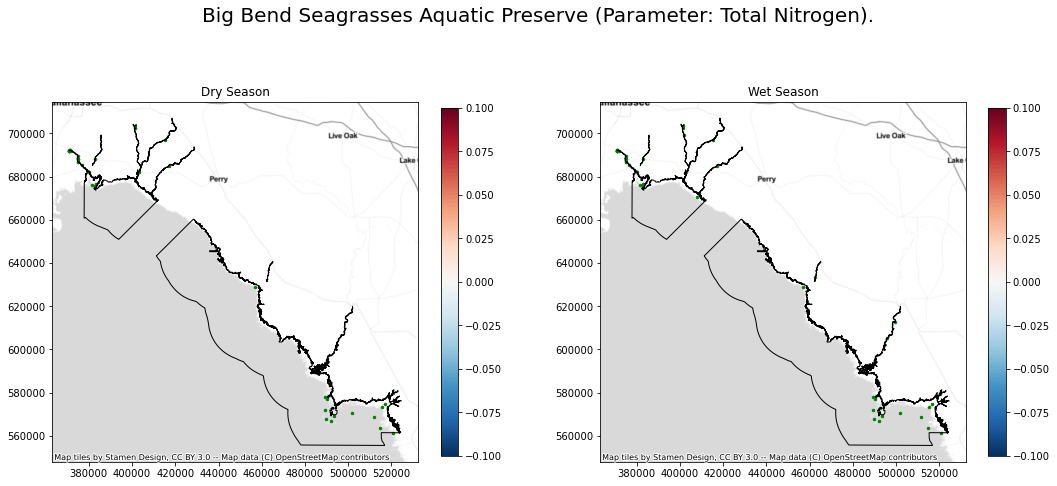

In [63]:
fig, axes = plt.subplots(1,2, figsize=(18, 8))

fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)

misc.interpolation.plot_raster(gdfDryShp, extentShp, dryRK_2017, 'Dry Season', axes[0],fig)
misc.interpolation.plot_raster(gdfWetShp, extentShp, wetRK_2017, 'Wet Season', axes[1],fig)


### 3.4.4 Interpolation Validation of Total Nitrogen <a class="anchor" id="tn_val"></a>

Validate RK with bathymetry

In [64]:
def extract_val_result(inLayer, index):
    cvResult = arcpy.CrossValidation_ga(inLayer)
    Stat = pd.DataFrame(
                {
                  "meanError": round(float(cvResult.meanError),4),
                  "meanStandardizedError": round(float(cvResult.meanStandardized),4),
                  "rootMeanSquareError": round(float(cvResult.rootMeanSquare),4)
                                              },index=[index])
    return Stat

In [65]:
method, season, covariate = 'rk', 'dry', 'bathymetry'
inLayer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate[0:5])

dryRKStat1 = extract_val_result(inLayer,covariate)

season = 'wet'
inLayer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate[0:5])

wetRKStat1 = extract_val_result(inLayer,covariate)

Display validation result

In [66]:
print("Validation of Regression Kriging in dry season data")
display(dryRKStat1)
print("Validation of Regression Kriging in wet season data")
display(wetRKStat1)

Validation of Regression Kriging in dry season data


,meanError,meanStandardizedError,rootMeanSquareError
bathymetry,-0.0442,-0.0908,0.2547


Validation of Regression Kriging in wet season data


,meanError,meanStandardizedError,rootMeanSquareError
bathymetry,-0.0371,-0.0898,0.2068


Validation of RK with ldi as covariate

In [67]:
method, season, covariate = 'rk', 'dry', 'ldi'
inLayer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate[0:5])

dryRKStat2 = extract_val_result(inLayer,covariate)

season = 'wet'
inLayer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate[0:5])

wetRKStat2 = extract_val_result(inLayer,covariate)

Display validation result

In [68]:
print("Validation of Regression Kriging in dry season data")
display(dryRKStat2)
print("Validation of Regression Kriging in wet season data")
display(wetRKStat2)

Validation of Regression Kriging in dry season data


,meanError,meanStandardizedError,rootMeanSquareError
ldi,-0.0327,-0.0502,0.2534


Validation of Regression Kriging in wet season data


,meanError,meanStandardizedError,rootMeanSquareError
ldi,-0.0259,-0.0644,0.2024


Validate RK with Bathymetry & LDI

In [69]:
method, season, covariate = 'rk', 'dry', 'b_ldi'
inLayer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate[0:5])

dryRKStat3 = extract_val_result(inLayer,covariate)

season = 'wet'
inLayer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate[0:5])

wetRKStat3 = extract_val_result(inLayer,covariate)

Display validation result

In [70]:
print("Interpolation assessment of Regression Kriging in dry season data")
display(dryRKStat3)
print("Interpolation assessment of Regression Kriging in wet season data")
display(wetRKStat3)

Interpolation assessment of Regression Kriging in dry season data


,meanError,meanStandardizedError,rootMeanSquareError
b_ldi,-0.0252,-0.0243,0.2311


Interpolation assessment of Regression Kriging in wet season data


,meanError,meanStandardizedError,rootMeanSquareError
b_ldi,-0.0251,-0.0628,0.2084


#### Summary of validation

In [71]:
sumStatDry_ch = pd.concat([dryRKStat1,dryRKStat2,dryRKStat3])
sumStatWet_ch = pd.concat([wetRKStat1,wetRKStat2,wetRKStat3])

display("Summary of interpolation validation in dry season data")
display(sumStatDry_ch)

display("Summary of interpolation validation in wet season data")
display(sumStatWet_ch)

'Summary of interpolation validation in dry season data'

,meanError,meanStandardizedError,rootMeanSquareError
bathymetry,-0.0442,-0.0908,0.2547
ldi,-0.0327,-0.0502,0.2534
b_ldi,-0.0252,-0.0243,0.2311


'Summary of interpolation validation in wet season data'

,meanError,meanStandardizedError,rootMeanSquareError
bathymetry,-0.0371,-0.0898,0.2068
ldi,-0.0259,-0.0644,0.2024
b_ldi,-0.0251,-0.0628,0.2084
